 # Statoil/C-Core 튜토리얼 - Image recognition ans Binary classfication

 위성사진을 통해 빙하와 배를 구분하는 문제입니다. 
 -> 캐나다 동쪽 해안의 표류하는 빙하가  자칫 위험이 될 수 있어, 기업들이 이를 해결하기 위해 노력하고 있다고 합니다..
 그래서 이번의 과제의 목표는 Ship과 Iceberg를 잘 구분해내는 머신러닝, 딥러닝 모델을 세우는것이 목표입니다.
 
 - 이번 Compitition은 Image Classification이며, BinaryClassfication 입니다.
 - Keras를 통한 2-D Convolutional Neural Network(CNN)과 Plotly를 배울 것입니다.
 (Keras - 딥러닝 프레임워크, Plotly -> Interative한 Visualization을 가능하게 하는 라이브러리)

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

#plt.rcParams['figure.figsize'] = 12, 8
%matplotlib inline

#Take a Loog at a iceberg

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

py.init_notebook_mode(connected=True)
#plotly를 jupyter notebook에 사용하려면 위의 문장을 꼭 입력 할 것 !

In [3]:
# Load data
train = pd.read_json("input/data/processed/train.json")
test = pd.read_json("input/data/processed/test.json")
train.inc_angle = train.inc_angle.replace('na',0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
print("done!")

done!


In [4]:
train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


위 데이터를 보게되면, ID(고유), feature론  band_1,2, inc_angle이 있습니다.
여기서 우리가 맞춰야할 target은 is_iceberg로 1이면 iceberg, 0이면 ship입니다.

    데이터에 대한 설명은 ( https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/overview/background )에 있습니다.

위성사진은 위성에서 쏜 radar가 특정  object를 만나면 bounce 하여 다시 돌아오게 되는데 이를 image로 저장한 것이 저희가 다운받은 데이터라고 합니다.

- Object가 Solid 할 수록 더 밝게 나옵니다,(rader energy가 강하게 reflection 되므로) 이때 반사되는 energy를 backscatter라고 합니다.

- Back scatter은 환경에 영향을 많이 받습니다. 바람이 강할수록 이미지가 밝아지고, 약할수록 어두워진다고 합니다.

- 현재 Image를 찍는 위성은 Sentinel-1으로 측방 감시 레이더라고 합니다. 특정 angle로 이미지를 본다고 할 수 있습니다. 위 데이터에서 inc_angle은 band_1,band_2 라는 이미지를 바라보는 angle을 의미합니다. 여기서 두 이미지는 상대적인 이미지라고 볼 수 있습니다.

- 일반적으로 높은 incidence Angle 일수록 배경인 바다가 어둡게 나온다고 합니다.

- 이때, band_1,2는 HH(transmit/receive horizontally)와 HW(transmit horizontally and receive vertically)로 얻어진 radar 데이터를 정제해 얻은 coefficient이며, 이미지라고 생각하면 된다고 합니다.

이제, band_1,2를 75X75로 바꾸고 2D CNN 학습을 위해 [[N, height, width, channel]]의 차원을 가지게 바꿔줘야 합니다. np.newaxis를 사용하면 됩니다.

# CNN (Convolution Neural Network)

합성공 신경망으로 불리며, 기존의 FCNN과 비교했을때 공간 정보를 유지하면서 데이터를 학습할 수 있으며, Pooling Layer을 사용해 출력 데이터의 크기를 줄이거나 강조할 수 있다.(주로 Max Pooling을 많이 사용합니다.)



In [5]:
# 학습데아터 생성 
# HH와 HV 그리고 그 두개의 평균값을 가진 3개의 bands를 생성
# concatenate는 numpy의 배열을 합치는 함수로 axis를 조절해 사용한다.
# newaxis는 축을 추가하는 함수로 2D는 3D가, 3D는 4D가 되는 것이다.
# https://azanewta.tistory.com/3 여기에 보면 newaxis에 대해 reshape와 다른 점이 잘 설명돼있다.

X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train["band_1"]])
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:,:,:,np.newaxis],X_band_2[:,:,:,np.newaxis],((X_band_1 + X_band_2)/2)[:,:,:,np.newaxis]],axis=-1)


In [11]:
# plotly의 surface plot를 활용하면 3-D plot를 얻을 수 있으며 이를 활용해 Ship과 Iceberg가 가지는 band_1, band_2가 각각 어떻게 다른지 확인 할 수 있습니다.
# 또, matplotlib의 imshow를 이용해 2-D로 쉽게 그릴 수 있습니다. Python의 대표적인 시각화 함수들 -> Matplotlib, seaborn, plotly
# 이 함수는 데이터 셋에 있는 한 줄(행)을 들고와서 그 행의 데이터를 시각적으로 보여주는 함수입니다,
def plot_2d(band1,band2,label):
    fig = tools.make_subplots(rows=1,cols=2, specs=[[{'is_3d': True}, {'is_3d':True}]])
    fig.append_trace(dict(type = 'surface',z=band1,colorscale='RdBu', scene="scene1", showscale=False),1,1)
    fig.append_trace(dict(type = 'surface',z=band2,colorscale='RdBu', scene="scene2", showscale=False),1,2)
    
    fig['layout'].update(title="3D surface plot for '{}' (left is from band1, right is from band2)".format(label),titlefont=dict(size=30),height=800,width=1200)
    
    py.iplot(fig)
    
    fig, ax = plt.subplots(1, 2, figsize = (16,10))
    ax[0].imshow(X_band_1[num,:,:])#3차원
    ax[0].set_title('Image from band_1',fontsize=15)
    ax[1].imshow(X_band_2[num,:,:])#3차원
    ax[1].set_title('Image from band_2',fontsize=15)
    plt.show() 

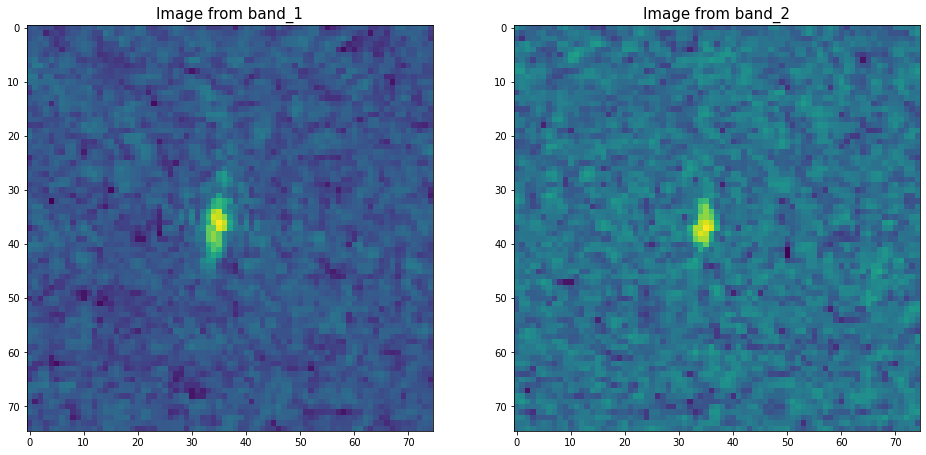

In [12]:
# Ship의 band_1, band_2
num = 0
label = 'iceberg' if (train['is_iceberg'].values[num] == 1) else 'ship'
plot_2d(X_band_1[num,:,:],X_band_2[num,:,:],label)

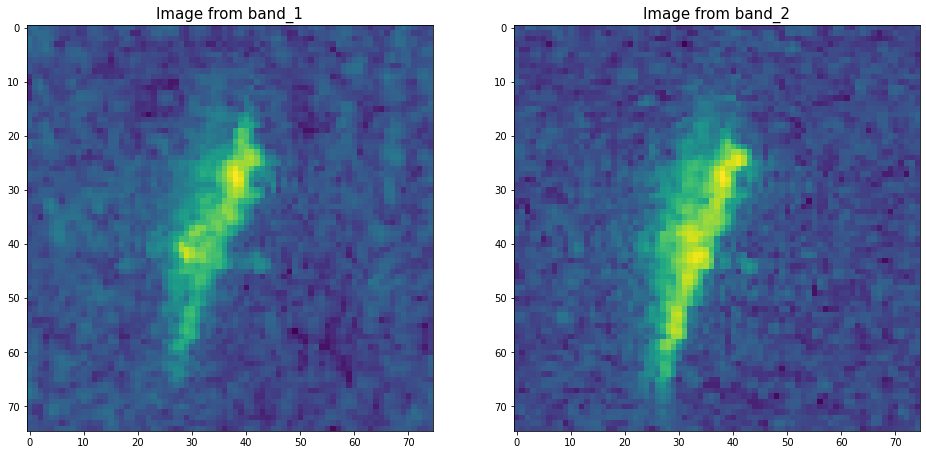

In [20]:
# Ship의 band_1, band_2
num = 301 #302 : iceberg
label = 'iceberg' if (train['is_iceberg'].values[num] == 1) else 'ship'
plot_2d(X_band_1[num,:,:],X_band_2[num,:,:],label)

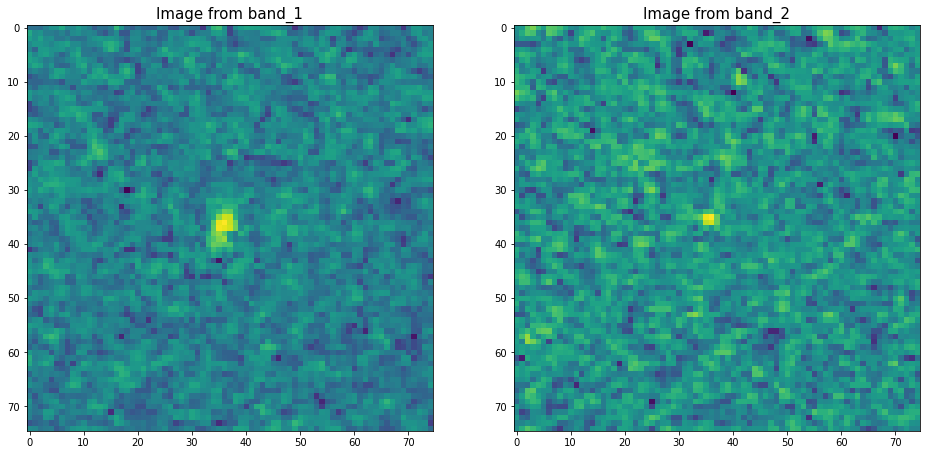

In [16]:
# iceberg의 band_1, band_2
num = 2
label = 'iceberg' if (train['is_iceberg'].values[num] == 1) else 'ship'
plot_2d(X_band_1[num,:,:],X_band_2[num,:,:],label)

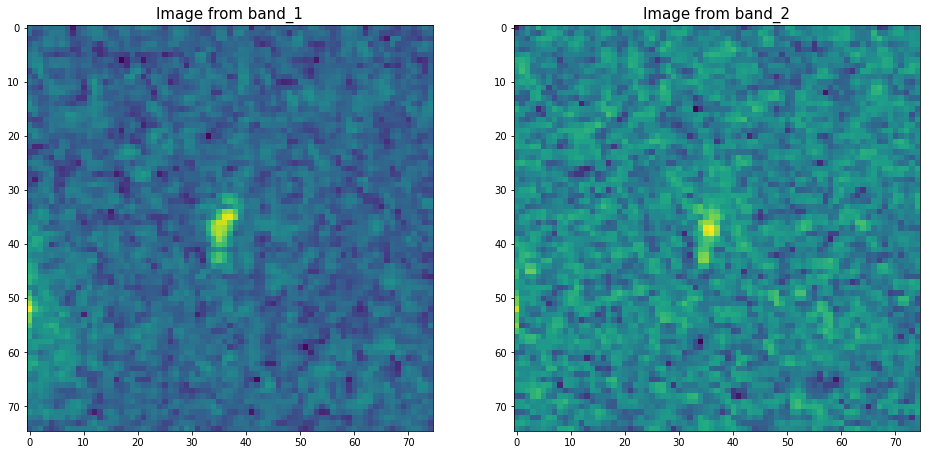

In [17]:
# iceberg의 band_1, band_2
num = 125
label = 'iceberg' if (train['is_iceberg'].values[num] == 1) else 'ship'
plot_2d(X_band_1[num,:,:],X_band_2[num,:,:],label)

In [21]:
# import keras
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [ ]:
# callback 을 사용하여, loss 가 더 줄지 않을 때 학습을 멈춰줍니다.

def Model():
    gmodel = sequential()

# Reference

https://kaggle-kr.tistory.com/19?category=868316
https://pod3275.github.io/paper/2019/05/31/Dropout.html

